# Imports

In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders as ce
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, power_transform, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score,
                            recall_score,
                            f1_score,
                            accuracy_score,
                            roc_auc_score,
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            make_scorer,
                            RocCurveDisplay,
                            auc,
                            roc_curve,
                            precision_recall_curve)

from sklearn.base import BaseEstimator, TransformerMixin

from pandas_profiling import ProfileReport

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
%matplotlib inline

# Custom transformer imports

In [2]:
# WIP preprocessor which assigns categories and compresses some code
from custom_transformers.preprocessor import ColumnConverter

# WIP ordinal category preprocessor
from custom_transformers.custom_ordinal_encoder import custom_oe

#WIP column selector
from custom_transformers.featureselector import SelectColumns

# WIP onehot category preprocessor
from custom_transformers.custom_onehot_encoder import custom_one_hot

# WIP onehot category preprocessor
from custom_transformers.custom_impute_scale import custom_impute_scale


# Functions

In [3]:
def load_train_data():
    df = pd.read_csv(os.path.join("data", "train_data.csv"))
    return df

data_train = load_train_data()

In [4]:
def assign_index(df, indexcol: str):
    _df = df.copy()
    _df = _df.set_index(indexcol)
    return _df

In [5]:
def build_target(df, target: str):
    _df = df.copy()
    _df[target] = np.where(_df[target]== 'Yes', True, False)
    return _df

# Function to test if we satisfied requirements:

The first step will make a copy of the X_test and apply the custom converter for the columns - it will update the categories we are interested in (avoid duplicates etc)

In [6]:
def verify_no_discrimination(X_test,
                             y_true,
                             y_pred,
                             sensitive_columns = [],
                             max_diff=0.1,
                             average='weighted'):    
    # Use this as a template to get output:
    #f1_scores, diff, is_satisfied  = verify_no_discrimination(X_test,
    #                                                          y_test,
    #                                                          y_pred,
    #                                                          sensitive_column=['Self-defined ethnicity', 'race'] etc
    #                                                          max_diff=0.15 )
    #f1_scores, diff, is_satisfied
    
    _df = X_test.copy()
    
    results = {}
    
    cc = ColumnConverter()
    _df = cc.fit_transform(_df)
    
    for column in sensitive_columns:  
        sensitive_classes = _df[column].unique()
        is_satisfied = True
        f1_scores = {}
        
        for sensitive_class in sensitive_classes:
            mask = (_df[column] == sensitive_class)
            if mask.sum():
                f1_scores[sensitive_class] = f1_score(y_true[mask],
                                                      y_pred[mask],
                                                      pos_label=1,
                                                      labels=np.unique(y_pred[mask]))
        
        diff = np.max(list(f1_scores.values())) - np.min(list(f1_scores.values()))
        if diff > max_diff:
            is_satisfied = False
        
        results[column] = [f1_scores, diff, is_satisfied]
    
    return results

In [7]:
def verify_no_discrimination_2(X_test,
                               y_true,
                               y_pred,
                               sensitive_columns = [],
                               max_diff=0.1,
                               average='weighted',
                               min_samples=50):    
    # This time with precision
    
    _df = X_test.copy()
    
    results = {}
    
    cc = ColumnConverter()
    _df = cc.fit_transform(_df)
    
    for column in sensitive_columns:  
        sensitive_classes = _df[column].unique()
        is_satisfied = True
        precision_scores = {}
        
        for sensitive_class in sensitive_classes:
            mask = (_df[column] == sensitive_class)
            if np.sum(mask) > min_samples:
                precision_scores[sensitive_class] = precision_score(y_true[mask],
                                                      y_pred[mask],
                                                      pos_label=1,
                                                      labels=np.unique(y_pred[mask]))
        
        diff = np.max(list(precision_scores.values())) - np.min(list(precision_scores.values()))
        if diff > max_diff:
            is_satisfied = False
        
        results[column] = [precision_scores, diff, is_satisfied]
    
    return results

# Loading data

In [8]:
target = 'readmitted'
index_col = 'admission_id'

In [9]:
data_train = load_train_data()
data_train = assign_index(data_train, index_col)
data_train = build_target(data_train, target)

In [10]:
#List of all features (n=numerical, uc=unordered actegory, oc=ordered category, b=boolean)

all_features = ['patient_id', #identifier
                'race', #uc
                'gender', #uc
                'age', #oc
                'weight', #oc               
                'admission_type_code', #uc
                'discharge_disposition_code', #uc
                'admission_source_code', #uc
                'time_in_hospital', #n
                'payer_code', #uc
                'medical_specialty', #uc
                'has_prosthesis', #b
                'complete_vaccination_status', #uc
                'num_lab_procedures', #n
                'num_procedures', #n
                'num_medications', #n
                'number_outpatient', #n
                'number_emergency', #n
                'number_inpatient', #n
                'diag_1', #uc
                'diag_2', #uc
                'diag_3', #uc
                'number_diagnoses', #n
                'blood_type', #uc
                'hemoglobin_level', #n
                'blood_transfusion', #b
                'max_glu_serum', #oc
                'A1Cresult', #oc
                'diuretics', #b
                'insulin', #b
                'change', #b
                'diabetesMed'] #b]

num_features = ['time_in_hospital', 
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'number_diagnoses',
                'hemoglobin_level']

bool_features = ['has_prosthesis',
                 'blood_transfusion',
                 'diuretics',
                 'insulin',
                 'change',
                 'diabetesMed']

cat_features = ['race',
                'gender',
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'payer_code',
                'medical_specialty',
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type']

ord_cat_features = ['age',
                    'weight',
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

# missing features: date of admission and date of release

### Test train split

In [11]:
# Convert target to boolean

# We have a small portion kept aside because of our random undersampling approach where we lose a lot of train data 
#df_train, df_test = train_test_split(data_train, test_size=0.1, random_state=42, stratify=data_train[target])

df_train, df_test = train_test_split(data_train, test_size=0.1, random_state=42, stratify=None, shuffle=False)

### Dealing with unbalanced train data:
1. Going to use random oversampling

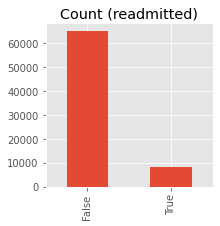

In [12]:
plt.rcParams["figure.figsize"] = [3, 3]
df_train[target].value_counts().plot(kind='bar', title='Count (readmitted)');

In [13]:
# get counts and split tables
count_f, count_t = df_train[target].value_counts()
df_f = df_train[df_train[target] == False]
df_t = df_train[df_train[target] == True]

### Random oversampling of the positive (True) class

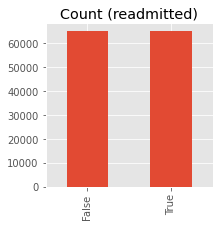

In [14]:
# oversampling (lots of duplication of positive classes)
df_t_oversampled = df_t.sample(count_f, replace=True)
df_train_oversampled = pd.concat([df_t_oversampled, df_f], axis=0)
#sort it to maintain some kind of order
df_train_oversampled = df_train_oversampled.sort_index()
#plot it
df_train_oversampled[target].value_counts().plot(kind='bar', title='Count (readmitted)');

### Test train split and selection

In [84]:
# without random oversampling
#X_train = df_train.drop(target, axis=1)
#y_train = df_train[target]

# with random oversampling
X_train = df_train_oversampled.drop(target, axis=1)
y_train = df_train_oversampled[target]

#test data
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [16]:
selected_features = ['time_in_hospital', 
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'hemoglobin_level',
                     
                     #'has_prosthesis',
                     'blood_transfusion',
                     #'diuretics',
                     'insulin',
                     'change',
                     'diabetesMed',
                     
                     'race',
                     'gender',
                     'admission_type_code', 
                     'discharge_disposition_code',
                     'admission_source_code', 
                     'payer_code',
                     #'medical_specialty',
                     #'complete_vaccination_status',
                     'blood_type',
                     'diag_1',
                     'diag_2',
                     'diag_3',
                     
                     'max_glu_serum',
                     'A1Cresult',
                     'age',
                     #'weight'
                    ]

In [17]:
num_feats = [feat for feat in selected_features if feat in num_features]
cat_feats = [feat for feat in selected_features if feat in cat_features+bool_features+ord_cat_features]
bool_feats = [feat for feat in selected_features if feat in bool_features]
ord_cat_feats = [feat for feat in selected_features if feat in ord_cat_features]

In [18]:
ord_cat_features = ['age',
                    'weight', #lots of missing or unknown values
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

In [19]:
cat_features = ['race', #done
                'gender', #done
                'admission_type_code', #done 
                'discharge_disposition_code', #done
                'admission_source_code', # done 
                'payer_code', #done (now the insurance column)
                #'medical_specialty', #done (any specialty over 100 - lets see how bad it gets)
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type'
               ] #dropping blood type

1. Not using blood type
1. Not using weight
1. Not using diagnoses: probably linked to medical specialty
    1. Will be added in the next version
1. Admission source not yet included
1. Race, gender and payer code (SP=uninsured) will not be used to model

##### Processing Diagnoses:
1. High cardinality (and possibly redundant information due to overlpa with the speecialty?)

In [20]:
# This needs to become a custom pipeline - and we need different scalers here

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())]) #StandardScaler or MinMaxScaler
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', ce.OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_features)],
remainder="passthrough",sparse_threshold=0)

### Feature selection
1. Had to manually recreate the pipeline for this

In [21]:
# X = X_train.copy()
# y = y_train.copy()

In [22]:
# cc = ColumnConverter()
# X = cc.fit_transform(X)
# coe = custom_oe()
# X = coe.fit_transform(X)
# si1 = SimpleImputer(strategy='median')
# X[num_feats]= si1.fit_transform(X[num_feats])
# si2 = SimpleImputer(strategy='constant', fill_value='unknown')
# X[cat_features] = si2.fit_transform(X[cat_features])
# catenc = ce.OneHotEncoder(handle_unknown='ignore', cols=cat_features, use_cat_names=True)
# X = catenc.fit_transform(X)

In [23]:
# clf = RandomForestClassifier(max_depth=10,
#                              class_weight="balanced",
#                              random_state=42, n_jobs=-1,
#                              n_estimators = 1000,
#                              criterion = 'gini',
#                              max_features = 'auto',
#                              bootstrap = False)
# clf.fit(X, y)

In [24]:
# feature_importances = clf.feature_importances_

In [25]:
# plt.rcParams["figure.figsize"] = [4, 30]

In [26]:
# pd.Series(clf.feature_importances_, index=X.columns).plot.barh(title='feature importances');

# plt.title('Random Forest feature importances')
# plt.xlabel('Importance');
# plt.ylabel('Feature');

### Gridsearch
1. Had to manually recreate the pipeline for this

In [27]:
X = X_train.copy()
y = y_train.copy()

In [28]:
parameters = {
    'max_depth': [2, 5, 10],
    'max_features': ['auto', 'log2'],
    'class_weight': ["balanced"],
    'n_estimators': [10, 100, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'min_samples_split': [2, 5, 10]
             }

In [29]:
grid_search_pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                           parameters,
                           cv=5,
                           scoring="f1",
                           return_train_score=True))


In [30]:
# %%timeit -n 1 -r 1
# grid_search_pipeline.fit(X_train, y_train)
# grid_search_pipeline.named_steps.gridsearchcv
# grid_search_pipeline.named_steps.gridsearchcv.best_params_

# Random Forest

In [31]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    RandomForestClassifier(max_depth=10,
                           class_weight="balanced",
                           random_state=42, n_jobs=-1,
                           n_estimators = 1000,
                           criterion = 'gini',
                           max_features = 'auto',
                           bootstrap = False),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.28563982277821215
recall score: 0.631336405529954
precision score: 0.18457393061636915
discrimination results:


In [32]:
# verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])
verify_no_discrimination_2(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

{'medical_specialty': [{'cardiology': 0.11392405063291139,
   'unknown': 0.191025641025641,
   'internalmedicine': 0.14698795180722893,
   'emergency/trauma': 0.17712177121771217,
   'family/generalpractice': 0.22535211267605634,
   'nephrology': 0.22058823529411764,
   'psychiatry': 0.125,
   'surgery-cardiovascular/thoracic': 0.0,
   'pulmonology': 0.26666666666666666,
   'other': 0.2222222222222222,
   'surgery-general': 0.2111111111111111,
   'orthopedics': 0.16216216216216217,
   'urology': 0.1,
   'radiologist': 0.2,
   'orthopedics-reconstructive': 0.1388888888888889,
   'gastroenterology': 0.2},
  0.26666666666666666,
  False],
 'payer_code': [{'insured': 0.17491749174917492,
   'unknown': 0.20423892100192678,
   'SP': 0.1592920353982301},
  0.044946885603696696,
  True],
 'gender': [{'male': 0.19147344801795063, 'female': 0.17892156862745098},
  0.012551879390499648,
  True],
 'race': [{'white': 0.17792207792207793,
   'unknown/other': 0.21428571428571427,
   'black': 0.201941

In [33]:
plt.rcParams["figure.figsize"] = [3, 3]

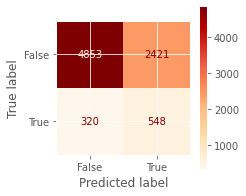

In [34]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

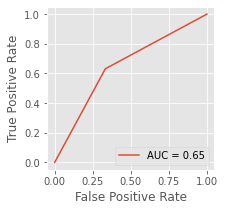

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

### Evaluation and setting threshold:
1. The client wants at least 50% to be correct

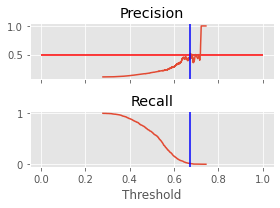

In [36]:
y_pred_probas = pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
threshold_rq = thresholds[min_index]
y_pred = (y_pred_probas >= threshold_rq)
plt.rcParams["figure.figsize"] = [4, 3]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
precision = precision[:-1]
recall = recall[:-1]
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax1.axvline(x=threshold_rq, color='blue')
ax2.set_title('Recall')
ax2.axvline(x=threshold_rq, color='blue')
fig.tight_layout()
plt.show()

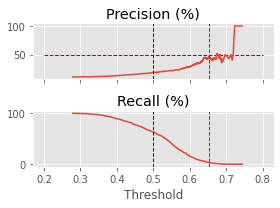

In [85]:
y_pred_probas = pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
y_pred = (y_pred_probas >= threshold_rq)
plt.rcParams["figure.figsize"] = [4, 3]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
precision = precision[:-1]
recall = recall[:-1]
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(thresholds,precision*100)
ax2.plot(thresholds,recall*100)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision (%)')
ax1.axvline(x=0.5, color='blue', linestyle="--", linewidth=1)
ax1.axvline(x=threshold_rq, color='green', linestyle="--", linewidth=1)
ax2.set_title('Recall (%)')
ax2.axvline(x=0.5, color='blue', linestyle="--", linewidth=1)
ax2.axvline(x=threshold_rq, color='green', linestyle="--", linewidth=1)
ax1.hlines(y=50,xmin=0.2, xmax=0.8, colors='purple', linestyle="--", linewidth=1)
fig.tight_layout()
plt.show()

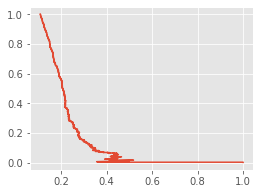

In [51]:
plt.plot(precision, recall);

In [38]:
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.03125
recall score: 0.016129032258064516
precision score: 0.5
discrimination results:


In [39]:
threshold_rq

0.6736832090192096

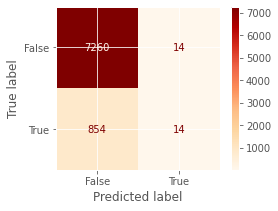

In [40]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

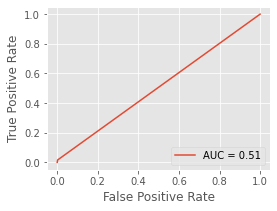

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

In [42]:
raise Notimplemented

NameError: name 'Notimplemented' is not defined

# Trying to optimize

Best Threshold=0.497078, G-Mean=0.652


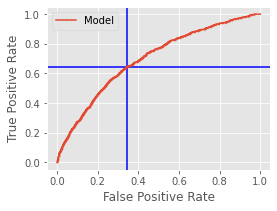

In [86]:
y_pred_probas
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.axvline(x=fpr[ix], color='blue')
plt.axhline(y=tpr[ix], color='blue')
plt.plot(fpr, tpr, marker='.', label='Model', markersize=0.5)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

In [53]:
thresholds[ix]

0.49707825560208574

In [54]:
y_pred = (y_pred_probas >= thresholds[ix])
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.28629856850715746
recall score: 0.6451612903225806
precision score: 0.18396846254927726
discrimination results:


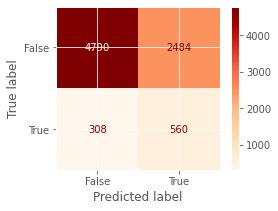

In [55]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

Best Threshold=1.000000, F-Score=0.286


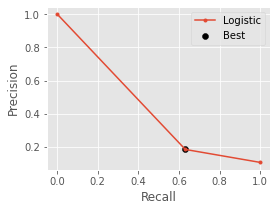

In [56]:
y_pred = (y_pred_probas >= 0.5)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

# Output files (pickling)

In [ ]:
TMP_DIR = '/tmp'
with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

with open(os.path.join(TMP_DIR, "dtypes.pickle"), 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
joblib.dump(pipeline, os.path.join(TMP_DIR, 'pipeline.pickle')) 

# Alternative using additional custom transformers
1. These transformers were very sensitive and kept breaking
1. Somehow this also worsened the resul (even though it followed the same methodology?)

In [ ]:
# selected_features = ['time_in_hospital', 
#                      'num_lab_procedures',
#                      'num_procedures',
#                      'num_medications',
#                      'number_outpatient',
#                      'number_emergency',
#                      'number_inpatient',
#                      'number_diagnoses',
#                      'hemoglobin_level',
                     
#                      'has_prosthesis',
#                      'blood_transfusion',
#                      'diuretics',
#                      'insulin',
#                      'change',
#                      'diabetesMed',
                     
#                       'race',
#                       'gender',
#                       'admission_type_code', 
#                       'discharge_disposition_code',
#                       'admission_source_code', 
#                       'payer_code',
#                       'medical_specialty',
#                       'complete_vaccination_status',
#                       'blood_type',
#                       'diag_1',
#                       'diag_2',
#                       'diag_3',
                     
#                      'max_glu_serum',
#                      'A1Cresult',
#                      'age',
#                      'weight']

In [ ]:
# pipeline = make_pipeline(
#     ColumnConverter(), #Does quick clean up, assigns datatypes and categories
#     custom_oe(), #Handles encoding of ordinal variables
#     custom_impute_scale(), #potential problem
#     SelectColumns(cols=selected_features),
#     custom_one_hot(), #one hot encoding for categories
#     RandomForestClassifier(max_depth=10,
#                            class_weight="balanced",
#                            random_state=42, n_jobs=-1,
#                            n_estimators = 10,
#                            criterion = 'gini',
#                            max_features = 'auto',
#                            bootstrap = False),
# )
# pipeline.fit(X_train, y_train)

# y_pred = pipeline.predict(X_test)

# print("f1 score: %s" % (f1_score(y_test, y_pred)))
# print("recall score: %s" % (recall_score(y_test, y_pred)))
# print("precision score: %s" % (precision_score(y_test, y_pred)))
# print("discrimination results:")

# Testing for the server

In [ ]:
# pipeline.predict(X_test.head(2))

In [ ]:
# t_pred_dict = X_test.iloc[0].to_dict()
# t_pred_dict['admission_id'] = X_test.index.tolist()[0]
# t_pred_dict

In [ ]:
# f_pred_dict = X_test.iloc[1].to_dict()
# f_pred_dict['admission_id'] = X_test.index.tolist()[1]
# f_pred_dict

#### This one works local

~ > curl -X POST http://localhost:5000/predict -d '{
	"patient_id": 169800930,
	"race": "Caucasian",
	"gender": "Male",
	"age": "[60-70)",
	"weight": "[100-125)",
	"admission_type_code": null,
	"discharge_disposition_code": 6.0,
	"admission_source_code": 1,
	"time_in_hospital": "2",
	"payer_code": "?",
	"medical_specialty": "Surgery-General",
	"has_prosthesis": true,
	"complete_vaccination_status": "Complete",
	"num_lab_procedures": 14.0,
	"num_procedures": 1,
	"num_medications": null,
	"number_outpatient": 0,
	"number_emergency": 0,
	"number_inpatient": 0,
	"diag_1": "715",
	"diag_2": "733",
	"diag_3": "250",
	"number_diagnoses": 5,
	"blood_type": "B+",
	"hemoglobin_level": 13.2,
	"blood_transfusion": true,
	"max_glu_serum": "None",
	"A1Cresult": "None",
	"diuretics": "No",
	"insulin": "No",
	"change": "No",
	"diabetesMed": "Yes",
	"admission_id": 58776
}' -H "Content-Type:application/json"

##### From the testing rounds

~ > curl -X POST http://localhost:5000/predict -d '{"index": 20020, "admission_id": 92775, "patient_id": 107572680, "race": "Caucasian", "gender": "Female", "age": "[40-50)", "weight": "?", "admission_type_code": NaN, "discharge_disposition_code": 1.0, "admission_source_code": 1, "time_in_hospital": 2, "payer_code": "CP", "medical_specialty": "InternalMedicine", "has_prosthesis": false, "complete_vaccination_status": "Complete", "num_lab_procedures": 61.0, "num_procedures": 0, "num_medications": 17.0, "number_outpatient": 0, "number_emergency": 0, "number_inpatient": 1, "diag_1": "250.03", "diag_2": "276", "diag_3": "401", "number_diagnoses": 8.0, "blood_type": "B-", "hemoglobin_level": 13.2, "blood_transfusion": false, "max_glu_serum": "None", "A1Cresult": "None", "diuretics": "No", "insulin": "No", "change": "No", "diabetesMed": "No"}' -H "Content-Type:application/json"

~ > curl -X POST http://localhost:5000/update -d '{ "readmitted": "No", "admission_id": 58776 }' -H "Content-Type:application/json"

#### This should work online

curl -X POST https://app-nb-3.herokuapp.com/predict -d '{ "patient_id": 169800930, "race": "Caucasian", "gender": "Male", "age": "[60-70)", "weight": "[100-125)", "admission_type_code": null, "discharge_disposition_code": 6.0, "admission_source_code": 1, "time_in_hospital": "2", "payer_code": "?", "medical_specialty": "Surgery-General", "has_prosthesis": true, "complete_vaccination_status": "Complete", "num_lab_procedures": 14.0, "num_procedures": 1, "num_medications": null, "number_outpatient": 0, "number_emergency": 0, "number_inpatient": 0, "diag_1": "715", "diag_2": "733", "diag_3": "250", "number_diagnoses": 5, "blood_type": "B+", "hemoglobin_level": 13.2, "blood_transfusion": true, "max_glu_serum": "None", "A1Cresult": "None", "diuretics": "No", "insulin": "No", "change": "No", "diabetesMed": "Yes", "admission_id": 58776 }' -H "Content-Type:application/json"






curl -X POST https://app-nb-3.herokuapp.com/update -d '{ "readmitted": "No", "admission_id": 58776 }' -H "Content-Type:application/json"

# Analysis after moment 1

# Loading data

In [57]:
def load_moment_1():
    data = pd.read_csv(os.path.join("data", "moment_1_requests.csv")).set_index('admission_id')
    moment_1 = (data.observation.apply(json.loads)
            .apply(pd.Series)
            .drop('index', axis=1)
            .drop('admission_id', axis=1))
    moment_1['predicted_readmitted'] = data['predicted_readmitted']
    moment_1['actual_readmitted'] = data['actual_readmitted']
    moment_1 = moment_1.drop(index=moment_1.index[0], axis=0)
    return moment_1

In [58]:
moment_1 = load_moment_1()
moment_1 = build_target(moment_1, 'predicted_readmitted')
moment_1 = build_target(moment_1, 'actual_readmitted')
moment_1.head()

,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,payer_code,...,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,predicted_readmitted,actual_readmitted
admission_id,,,,,,,,,,,,,,,,,,,,,
97265,215370.0,AfricanAmerican,Female,NaN,?,1.0,1.0,7.0,12,?,...,12.0,False,None,None,No,Yes,Ch,Yes,False,False
89653,168821964.0,Caucasian,Male,[50-60),?,3.0,1.0,1.0,1,MC,...,15.3,False,None,None,Yes,Yes,Ch,Yes,False,False
99518,1020438.0,African American,Male,[60-70),?,2.0,18.0,2.0,2,?,...,14.1,False,None,None,No,Yes,No,Yes,True,False
89397,141934014.0,AfricanAmerican,Female,[60-70),?,3.0,1.0,1.0,5,BC,...,13.4,False,NONE,None,No,Yes,No,Yes,False,False
83278,6485868.0,Hispanic,Male,[30-40),?,1.0,3.0,7.0,14,?,...,14.6,True,None,None,No,Yes,Ch,Yes,True,False


In [ ]:
moment_1.shape

# Looking at model performance after moment 1

False    6174
True     3493
Name: predicted_readmitted, dtype: int64

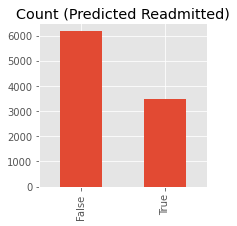

In [59]:
plt.rcParams["figure.figsize"] = [3, 3]
moment_1['predicted_readmitted'].value_counts().plot(kind='bar', title='Count (Predicted Readmitted)');
moment_1['predicted_readmitted'].value_counts()

False    8570
True     1097
Name: actual_readmitted, dtype: int64

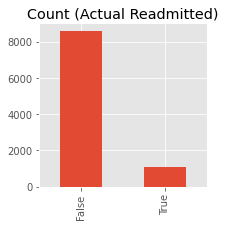

In [60]:
plt.rcParams["figure.figsize"] = [3, 3]
moment_1['actual_readmitted'].value_counts().plot(kind='bar', title='Count (Actual Readmitted)');
moment_1['actual_readmitted'].value_counts()

In [78]:
X_moment_1 = moment_1.drop(['predicted_readmitted', 'actual_readmitted'], axis=1)
y_pred = moment_1['predicted_readmitted']
y_test = moment_1['actual_readmitted']

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.2636165577342048
recall score: 0.5515041020966271
precision score: 0.17320354995705697
discrimination results:


In [79]:
verify_no_discrimination_2(X_test=X_moment_1, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

{'medical_specialty': [{'internalmedicine': 0.1987704918032787,
   'radiologist': 0.11538461538461539,
   'unknown': 0.16272677295217153,
   'family/generalpractice': 0.17870722433460076,
   'orthopedics': 0.1346153846153846,
   'emergency/trauma': 0.17777777777777778,
   'pulmonology': 0.16666666666666666,
   'other': 0.12121212121212122,
   'obstetricsandgynecology': 0.0,
   'cardiology': 0.1346153846153846,
   'surgery-general': 0.2604166666666667,
   'psychiatry': 0.3076923076923077,
   'orthopedics-reconstructive': 0.11764705882352941,
   'surgery-cardiovascular/thoracic': 0.0,
   'nephrology': 0.2641509433962264,
   'urology': 0.3,
   'gastroenterology': 0.125},
  0.3076923076923077,
  False],
 'payer_code': [{'unknown': 0.18725718725718726,
   'insured': 0.16626389560173996,
   'SP': 0.145985401459854},
  0.04127178579733326,
  True],
 'gender': [{'female': 0.17255096966683242, 'male': 0.17408906882591094},
  0.0015380991590785154,
  True],
 'race': [{'black': 0.1598101265822784

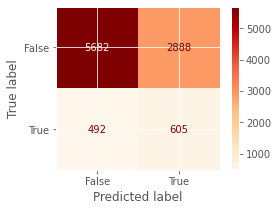

In [80]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

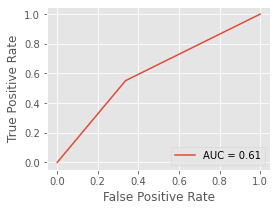

In [81]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)
# display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
# display.plot()
# plt.show()

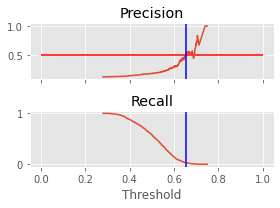

In [82]:
y_pred_probas = pipeline.predict_proba(X_moment_1)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
threshold_rq = thresholds[min_index]
y_pred = (y_pred_probas >= threshold_rq)
plt.rcParams["figure.figsize"] = [4, 3]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
precision = precision[:-1]
recall = recall[:-1]
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax1.axvline(x=threshold_rq, color='blue')
ax2.set_title('Recall')
ax2.axvline(x=threshold_rq, color='blue')
fig.tight_layout()
plt.show()

Best Threshold=0.750651, G-Mean=0.605


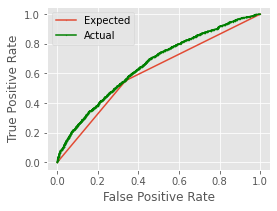

In [83]:
y_pred_probas
# calculate roc curves
fpr_1, tpr_1, thresholds = roc_curve(y_test, y_pred_probas)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


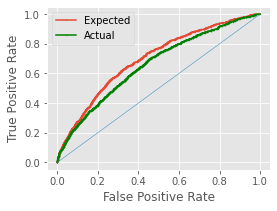

In [96]:
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='Expected', markersize=0.5)
plt.plot(fpr_1, tpr_1, marker='.', label='Actual', markersize=0.5, color='green')
plt.plot([0, 1], [0, 1], linewidth=0.5)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

In [ ]:
# verify_no_discrimination_2(X_test=X_moment_1, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

In [ ]:
y_pred_probas
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.axvline(x=fpr[ix], color='blue')
plt.axhline(y=tpr[ix], color='blue')
plt.plot(fpr, tpr, marker='.', label='Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();